Mass Hunter Example
===

Author: Nathan A. Mahynski

Date: 2024/11/14

Description: Example of how to create an interactive HTML file from MassHunter(TM) data.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/starlingrt/blob/main/docs/jupyter/mass_hunter.ipynb)

1. If you have not already installed starlingrt do so now.

In [1]:
# pip install starlingrt

In [2]:
import os
import starlingrt

from starlingrt import sample, data, functions, visualize

2. Write some code to locate all the MSRep.xls files you are going to compare.  Below is one example, however, you just need a list of `sample.MassHunterSample` objects to provide `starlingrt.data.Utilities.create_entries`.

In [3]:
?starlingrt.data.Utilities.create_entries

In [4]:
def load_mass_hunter(input_directory):
    """
    Load MassHunter(TM) data from the input directory.

    The data is assumed to be laid out in a tree structure like this:

    input_directory/
        FOLDER_YYYY_MM_DD.D/
            MSRep.xls
        FOLDER_YYYY_MM_DD.D/
            MSRep.xls
        FOLDER_YYYY_MM_DD.D/
            MSRep.xls
        ...

    Parameters
    ----------
    input_directory : str
        Directory to seach for raw folders are in.

    Returns
    -------
    samples : list(sample.MassHunterSample)
        List of Samples collected from all directories in `input_directory`.
    """
    samples = []
    folders = sorted([f for f in os.listdir(input_directory) if os.path.isdir(os.path.join(input_directory, f))])
    for f in folders:
        fname = os.path.join(input_directory, os.path.join(f, "MSRep.xls"))
        if os.path.isfile(fname):
            try:
                samples.append(
                    starlingrt.sample.MassHunterSample(fname)
                )
            except Exception as e:
                raise Exception(f'Unable to read {fname} : {e}')
        else:
            raise Exception(f'Could not locate MSRep.xls file in {fname}')

    return samples

3. Now let's select the "top" entries, that is, only the top (best quality, most confident) hit for each peak in all the files.

In [5]:
top_entries = starlingrt.data.Utilities.select_top_entries(
    starlingrt.data.Utilities.create_entries(
        load_mass_hunter(
            "../../../projects/completed/2023/2023-gcms-workflow/data/raw/sample_data/Med_2022_vhodni/"
        )
    )
)

4. To divide the compounds from each other we need a "gap" in retention times that divides them. A very large gap will make many compounds appear to all be in the same "bin" and be viewed as the same, while a very small gap will make every single peak appear to be belong to a unique compound (due to small, expected numerical fluctuations).  A balance of the two should provide a reasonable gap size that clumps things are "close enough" into one category/compound while keeping sufficiently different ones separate.  The graph below on the left (green curve) shows the number of unique retention time groups as this gap (threshold) is increased.  This is a monotonically decreasing function for the example data used.  Observe that the median entropy of these groups basically monotonically increases; the [(categorical) entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) of a group reflects the number of different compounds associated with that retention time window.  We are looking for *many* groups all of which represent unique compounds (low entropy); a product of these two curves yields a single maximum which we take as reflecting a good balance of these forces (graph below on right).  Here, this occurs at a retention time gap of 0.042.

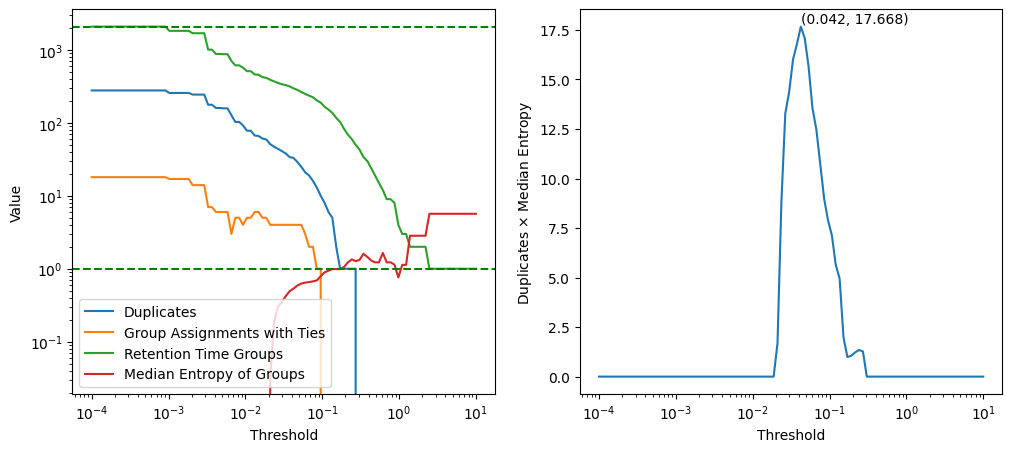

In [6]:
df, _, _ = starlingrt.functions.get_dataframe(top_entries)
threshold = starlingrt.functions.estimate_threshold(df, display=True)

5. Now let's use this gap to create our "unique" groups and initialize the interactive HTML table.  The user can manually adjust and examine the result from there.

In [7]:
threshold = starlingrt.functions.estimate_threshold(
    starlingrt.functions.get_dataframe(top_entries)[0], 
    display=False
)
print(f'Using a threshold of {threshold}')

Using a threshold of 0.04229242874389499


In [8]:
starlingrt.visualize.make(
    top_entries=top_entries, 
    width=1200,
    threshold=threshold,
    output_filename='summary.html',
)

6. Go to a browser and open 'summary.html'!